In [1]:
import math#from pynq import Overlay
from PIL import Image as PIL_Image
from PIL import ImageDraw as PIL_ImageDraw
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from pynq import MMIO
#from pynq import Xlnk
import time
import ctypes

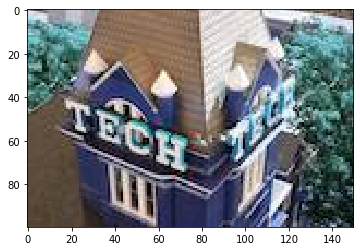

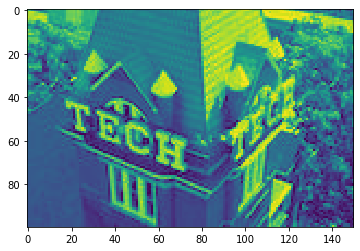

In [2]:
#image path 
ORIG_IMG_PATH   = 'gt_100.jpeg'

im=cv2.imread(ORIG_IMG_PATH)
gray=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(im)
plt.show()

plt.imshow(gray)
plt.show()

In [3]:

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)



In [4]:
def convolution(image, kernel, average=False, verbose=False):

    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))

        print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    start_time=time.time() 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image


    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()


    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    end_time=time.time()
    exec_time = end_time - start_time
    print("Elapsed time for Cov: {}".format(exec_time))
    
    print("Output Image size : {}".format(output.shape))


    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

In [5]:
def sobel_edge_detection(image, filter, verbose=False):
    new_image_x = convolution(image, filter, verbose)

    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

    new_image_y = convolution(image, np.flip(filter.T, axis=0), verbose)

    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()

    return gradient_magnitude

In [6]:
## calling gaussian blur and then call sobel edge detection 

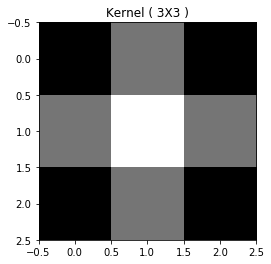

Image Shape : (100, 150)
Kernel Shape : (3, 3)


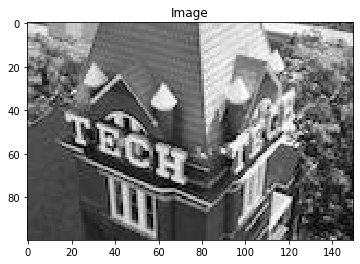

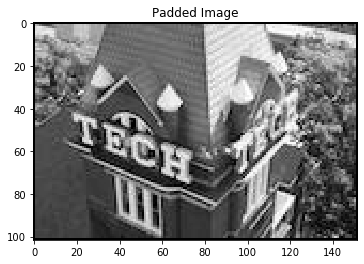

Elapsed time for Cov: 4.244738817214966
Output Image size : (100, 150)


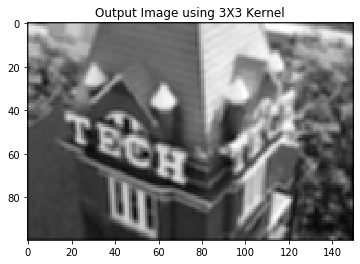

In [7]:
frame_g=gaussian_blur(gray, 3, True)

Image Shape : (100, 150)
Kernel Shape : (3, 3)
Elapsed time for Cov: 2.4488749504089355
Output Image size : (100, 150)


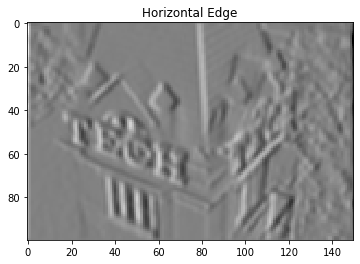

Image Shape : (100, 150)
Kernel Shape : (3, 3)
Elapsed time for Cov: 2.4304723739624023
Output Image size : (100, 150)


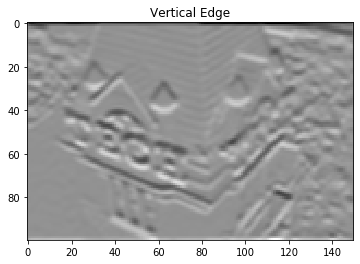

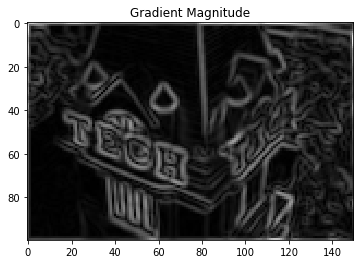

array([[177.00356934, 197.73678722, 204.05691612, ...,  94.62372052,
         84.01477361,  74.33992201],
       [208.93174062, 108.71718291, 113.55974532, ...,  47.30526494,
         47.80772612,  87.41078215],
       [231.1098361 ,  72.40021089,  32.76023697, ...,  26.23504585,
         42.60166498,  97.90603299],
       ...,
       [ 69.65398706,  21.89264437,   2.64752996, ...,  33.07080668,
         25.04797711,  26.83101222],
       [ 64.78486806,  28.98836555,  22.87069847, ...,  29.05228004,
         29.7933924 ,  30.99970914],
       [ 57.30089893,  64.2817705 ,  68.58189052, ...,  54.00393848,
         41.475649  ,  29.12977807]])

In [8]:
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_edge_detection(frame_g, filter, verbose=True)